<a href="https://colab.research.google.com/github/jordivg1/ARAP/blob/main/arap_2020_lab01_dqn_todo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Notebook created by [Víctor Campos](https://imatge.upc.edu/web/people/victor-campos) for UPC ETSETB AAL 2019

Updates:

[Xavier Giró](https://imatge.upc.edu/web/people/xavier-giro) - UPC ETSETB AAL 2019

# DQN example in PyTorch

This notebook is adapted from the [official DQN tutorial](https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html). Unlike the tutorial, we will use the standard observation instead of the RGB images.

In [ ]:
#@title Train/eval selection
#@markdown Sometimes the notebook will crash when running an evaluation rollout (with render=True) after training. If this happens, you can skip training and load a pre-trained model with the checkboxes below.

train_model = True #@param {type:"boolean"}
load_model = False #@param {type:"boolean"}


## Installing dependencies

We will use OpenAI Gym to simulate the environment, which might not be installed by default. We also need to install some dependencies for visualization purposes (this may take a while).

In [ ]:
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1

## Setting up the environment

We will need some tricks to visualize the simulations in the browser, as simply calling env.render() will not work in this notebook ([source](https://colab.research.google.com/drive/1flu31ulJlgiRL1dnN2ir8wGh9p7Zij2t#scrollTo=Jyb2Ujuozfi2&forceEdit=true&offline=true&sandboxMode=true)).

In [ ]:
import os
import gym
import time
import random
import numpy as np
import matplotlib.pyplot as plt
from collections import namedtuple

In [ ]:
from gym import logger as gymlogger
from gym.wrappers import Monitor
gymlogger.set_level(40) #error only

import math
import glob
import io
import base64
from IPython.display import HTML
from IPython import display as ipythondisplay

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
print('PyTorch version: ', torch.__version__)
print('Using GPU:', ['no', 'yes'][int(torch.cuda.is_available())])

PyTorch version:  1.7.0+cu101
Using GPU: yes


In [ ]:
from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400, 900))
display.start()

In [ ]:
def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else: 
    print("Could not find video")
    
def wrap_env(env):
  env = Monitor(env, './video', force=True)
  return env

## Visualize a random policy in the environment

Our goal is to train an agent that is capable of solving the CartPole problem, where a pole is attached to a cart moving along a horizontal track. The agent can interact with the environment by applying a force (+1/-1) to the cart. The episode is terminated whenever the pole is more than 15 degrees from vertical or the cart goes out of bounds in the horizontal axis. The agent receives +1 reward for each timestep under the desired conditions.

**Exercise #1.** Visualize a rollout of a random agent in the [CartPole-v1](https://gym.openai.com/envs/CartPole-v1/) environment. Use the [documentation](http://gym.openai.com/docs/) for OpenAI Gym as a reference.

In [ ]:
# Let's generate a random trajectory...

# Choose the Cart-Pole environment from the OpenAI Gym
env = wrap_env(gym.make("CartPole-v1"))

# Initialize the variables ob (observation=state), done (breaks loop) 
# and total_rew (reward)
ob, done, total_rew = env.reset(), False, 0

# Execution loop
while not done:
  env.render()
  
  # Sample a random action from the environment
  ac = env.action_space.sample()
  
  # Obtain the new state, reward and whether the episode has terminated
  ob, rew, done, info =  env.step(ac)
  
  # Accumulate the reward
  total_rew += rew
  
print('Cumulative reward:', total_rew)
  
# ... and visualize it!
env.close()
show_video()

Cumulative reward: 25.0


## Replay memory

The buffer will be a FIFO queue: when full, oldest experiences are removed to make room for new transitions.

**Exercise #2.** Implement the pointer to the next position to be filled in the replay memory, which corresponds to a FIFO queue.
(TIP: remember the [modulus % operator](https://python-reference.readthedocs.io/en/latest/docs/operators/modulus.html)).

In [ ]:
Transition = namedtuple(
    'Transition', ('state', 'action', 'next_state', 'reward'))


class ReplayMemory(object):
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, *args):
        """Saves a transition."""
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        # TODO: Update the pointer to the next position in the replay memory
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

## Create the model

Now we will define our policy, parameterized by a feedforward neural network.

**Exercise #3.** Complete the forward method of a [neural network in PyTorch](https://pytorch.org/tutorials/beginner/blitz/neural_networks_tutorial.html) by composing the two linear layer of perceptrons with a ReLU activation in between.

In [ ]:
class DQN(nn.Module):
    def __init__(self, inputs, outputs, hidden_size=128):
        super(DQN, self).__init__()
        self.affine1 = nn.Linear(inputs, hidden_size)
        self.affine2 = nn.Linear(hidden_size, outputs)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    # TODO: Define the operations in the forward pass. 
    def forward(self, x):
        x = self.affine1(x)
        x = F.relu(x)
        x = self.affine2(x)
        return x

## Functions for collecting experience and updating the policy

**Exercise #4.** Complete eps_greedy policy to facilitate the exploration.

**Exercise #5.** Complete with `policy_net` or `target_net` the `TODO_net` in the code.


In [ ]:
def compute_eps_threshold(step, eps_start, eps_end, eps_decay):
  return eps_end + (eps_start - eps_end) * math.exp(-1. * step / eps_decay)


def select_action(policy, state, eps_greedy_threshold, n_actions):
    # TODO: Select action using an epsilon-greedy strategy
    if random.random() > eps_greedy_threshold:
      with torch.no_grad():
            # t.max(1) will return largest column value of each row.
            # second column on max result is index of where max element was
            # found, so we pick action with the larger expected reward.
            action = policy(state).max(1)[1].view(1, 1)
            print(action)
    else:
      action = torch.tensor(
          [[random.randrange(n_actions)]], device=device, dtype=torch.long)
    return action

    
def train(policy_net, target_net, optimizer, memory, batch_size, gamma):
    if len(memory) < batch_size:
        return
    transitions = memory.sample(batch_size)
    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
    # detailed explanation). This converts batch-array of Transitions
    # to Transition of batch-arrays.
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(
        tuple(map(lambda s: s is not None, batch.next_state)), 
        device=device, 
        dtype=torch.bool)
    non_final_next_states = torch.cat(
        [s for s in batch.next_state if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Compute Q(s_t, a) - the model computes Q(s_t) for all a, then we select 
    # the columns of actions taken.
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # Compute Q(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1)[0].
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    # Note the call to detach() on Q(s_{t+1}), which prevents gradient flow
    next_state_values = torch.zeros(batch_size, device=device)
    next_state_values[non_final_mask] = target_net(
        non_final_next_states).max(1)[0].detach()
        
    # Compute targets for Q values: y_t = r_t + max(Q_{t+1})
    expected_state_action_values = reward_batch + (next_state_values * gamma)

    # Compute Pseudo-Huber loss between predicted Q values and targets y
    loss = F.smooth_l1_loss(
        state_action_values, expected_state_action_values.unsqueeze(1))

    # Take an SGD step
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    
def test(env, policy, render=False):
    state, ep_reward, done = env.reset(), 0, False
    while not done:
        if render:
          env.render()
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        action = select_action(policy_net, state, 0., 1)
        state, reward, done, _ = env.step(action.item())
        ep_reward += reward
    return ep_reward

## Training the agent

In [ ]:
# Hyperparameters
env_name = 'CartPole-v1'
gamma = 0.99  # discount factor
seed = 543  # random seed
log_interval = 25  # controls how often we log progress, in episodes
num_steps = 5e4  # number of steps to train on
batch_size = 256  # batch size for optimization
lr = 1e-4  # learning rate
eps_start = 1.0  # initial value for epsilon (in epsilon-greedy)
eps_end = 0.1  # final value for epsilon (in epsilon-greedy)
eps_decay = num_steps  # length of epsilon decay, in env steps
target_update = 1000  # how often to update target net, in env steps

In [ ]:
# The default reward is +1 for any (s,a) pair. We can make the task easier
# by giving a negative reward (e.g. -10) when the pole falls.
# You can try modifying/removing this reward shaping and see what happens.
# This is a clear example of the importance of reward in RL.
def reward_shaper(rew, done):
  return rew if not done else -10.

In [ ]:
# Create environment
env = gym.make(env_name)

# Fix random seed (for reproducibility)
env.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

In [ ]:
# Get number of actions from gym action space
n_inputs = env.observation_space.shape[0]
n_actions = env.action_space.n

**Exercise #6.** Complete the call to `memory_push`.

In [ ]:
if train_model:
  policy_net = DQN(n_inputs, n_actions).to(device)
  target_net = DQN(n_inputs, n_actions).to(device)
  target_net.load_state_dict(policy_net.state_dict())
  target_net.eval()

  optimizer = torch.optim.Adam(policy_net.parameters(), lr=lr)
  memory = ReplayMemory(10000)

  print("Target reward: {}".format(env.spec.reward_threshold))
  step_count = 0
  ep_rew_history = []
  i_episode, ep_reward = 0, -float('inf')
  while step_count < num_steps:
      # Initialize the environment and state
      state, done = env.reset(), False
      state = torch.from_numpy(state).float().unsqueeze(0).to(device)
      while not done:
          # Select an action
          eps_greedy_threshold = compute_eps_threshold(
              step_count, eps_start, eps_end, eps_decay)
          action = select_action(
              policy_net, state, eps_greedy_threshold, n_actions)

          # Perform action in env
          next_state, reward, done, _ = env.step(action.item())

          # Bookkeeping
          next_state = torch.from_numpy(
              next_state).float().unsqueeze(0).to(device)
          reward = reward_shaper(reward, done)
          reward = torch.tensor([reward], device=device)
          step_count += 1

          # Store the transition in memory
          memory.push(state,action,next_state,reward)

          # Move to the next state
          state = next_state

          # Perform one step of the optimization (on the policy network)
          train(policy_net, target_net, optimizer, memory, batch_size, gamma)
          
          # Update the target network, copying all weights and biases in DQN
          if step_count % target_update == 0:
              target_net.load_state_dict(policy_net.state_dict())

      i_episode += 1

      # Evaluate greedy policy
      if i_episode % log_interval == 0 or step_count >= num_steps:
          ep_reward = test(env, policy_net)
          ep_rew_history.append((i_episode, ep_reward))
          print('Episode {}\tSteps: {:.2f}k'
                '\tEval reward: {:.2f}'.format(
                i_episode, step_count/1000., ep_reward))

  print("Finished training! Eval reward: {:.2f}".format(ep_reward))
  if not os.path.exists('checkpoints'):
    os.makedirs('checkpoints')
  torch.save(policy_net.state_dict(), 'checkpoints/dqn-{}.pt'.format(env_name))

Se han truncado las últimas 5000 líneas del flujo de salida.
tensor([[1]], device='cuda:0')
tensor([[0]], device='cuda:0')
tensor([[1]], device='cuda:0')
tensor([[0]], device='cuda:0')
tensor([[1]], device='cuda:0')
tensor([[0]], device='cuda:0')
tensor([[1]], device='cuda:0')
tensor([[0]], device='cuda:0')
tensor([[1]], device='cuda:0')
tensor([[0]], device='cuda:0')
tensor([[1]], device='cuda:0')
tensor([[0]], device='cuda:0')
tensor([[1]], device='cuda:0')
tensor([[0]], device='cuda:0')
tensor([[0]], device='cuda:0')
tensor([[1]], device='cuda:0')
tensor([[0]], device='cuda:0')
tensor([[1]], device='cuda:0')
tensor([[0]], device='cuda:0')
tensor([[0]], device='cuda:0')
tensor([[1]], device='cuda:0')
tensor([[0]], device='cuda:0')
tensor([[1]], device='cuda:0')
tensor([[0]], device='cuda:0')
tensor([[1]], device='cuda:0')
tensor([[0]], device='cuda:0')
tensor([[1]], device='cuda:0')
tensor([[0]], device='cuda:0')
tensor([[1]], device='cuda:0')
tensor([[0]], device='cuda:0')
tensor([[

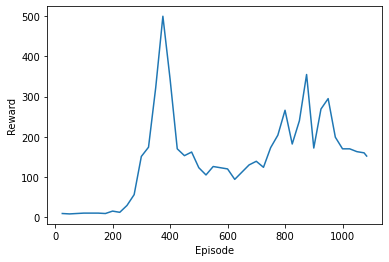

In [ ]:
if train_model:
  plt.plot([x[0] for x in ep_rew_history], [x[1] for x in ep_rew_history])
  plt.xlabel('Episode')
  plt.ylabel('Reward')

## Visualize trained policy

In [ ]:
if load_model:
  policy_net = DQN(n_inputs, n_actions).to(device)
  policy_net.load_state_dict(
      torch.load('checkpoints/dqn-{}.pt'.format(env_name)))
test_env = wrap_env(gym.make(env_name))
ep_reward = test(test_env, policy_net, render=True)
print("Cumulative reward: {}".format(ep_reward))

test_env.close()
show_video()

tensor([[1]], device='cuda:0')
tensor([[1]], device='cuda:0')
tensor([[1]], device='cuda:0')
tensor([[1]], device='cuda:0')
tensor([[0]], device='cuda:0')
tensor([[0]], device='cuda:0')
tensor([[1]], device='cuda:0')
tensor([[0]], device='cuda:0')
tensor([[0]], device='cuda:0')
tensor([[0]], device='cuda:0')
tensor([[0]], device='cuda:0')
tensor([[0]], device='cuda:0')
tensor([[0]], device='cuda:0')
tensor([[1]], device='cuda:0')
tensor([[1]], device='cuda:0')
tensor([[1]], device='cuda:0')
tensor([[1]], device='cuda:0')
tensor([[0]], device='cuda:0')
tensor([[0]], device='cuda:0')
tensor([[0]], device='cuda:0')
tensor([[0]], device='cuda:0')
tensor([[0]], device='cuda:0')
tensor([[1]], device='cuda:0')
tensor([[1]], device='cuda:0')
tensor([[1]], device='cuda:0')
tensor([[1]], device='cuda:0')
tensor([[1]], device='cuda:0')
tensor([[1]], device='cuda:0')
tensor([[0]], device='cuda:0')
tensor([[0]], device='cuda:0')
tensor([[0]], device='cuda:0')
tensor([[0]], device='cuda:0')
tensor([